#### 1. Load Data
#### 2. Data Scaling
#### 3. Implement PCA
#### 4. Split train test
#### 5. Implement SMOTEENN on training data

In [1]:
%config IPCompleter.greedy = True
%config IPCompleter.use_jedi = False

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, f1_score, recall_score, precision_score, accuracy_score, fbeta_score, roc_auc_score
from sklearn.decomposition import IncrementalPCA
from collections import Counter
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours, NeighbourhoodCleaningRule
from imblearn.over_sampling import SMOTE
import math
pd.set_option('display.max_columns', None)

### 1. Load Data

In [3]:
khs = pd.read_csv('Datasets/tidy_khs_plus_presensi.csv')

In [4]:
khs.drop(['MhswID'], axis=1, inplace=True)

In [5]:
khs

,IPS1,IPS2,IPS3,IPS4,IPS5,IPS6,IPS7,IPS8,SKS1,SKS2,SKS3,SKS4,SKS5,SKS6,SKS7,SKS8,P1,P2,P3,P4,P5,P6,P7,P8,AMS
0,3.15,2.53,2.16,2.48,2.75,2.63,2.69,1.80,17,31,44,62,81,97,119,123,0.00,0.00,0.00,0.00,79.47,82.41,67.36,64.95,1
1,1.82,3.18,3.67,3.55,4.00,3.57,4.00,4.00,55,74,101,121,129,136,138,142,0.00,0.00,0.00,0.00,97.62,96.43,0.00,0.00,0
2,2.54,2.74,1.83,2.67,2.50,2.57,2.43,2.00,23,42,52,70,88,102,112,122,0.00,0.00,0.00,0.00,89.08,86.10,67.76,82.00,1
3,3.75,3.53,3.25,4.00,3.55,3.36,3.67,2.86,20,39,59,78,98,120,135,139,0.00,0.00,99.11,0.00,93.49,93.91,96.29,89.13,0
4,3.15,2.95,3.10,2.84,3.00,3.10,3.00,3.00,17,33,50,69,95,115,130,140,0.00,0.00,89.76,0.00,80.76,76.23,67.84,51.37,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3157,3.45,3.82,3.74,3.33,3.70,4.00,3.80,4.00,18,40,63,87,110,125,135,139,100.00,96.29,0.00,98.70,97.40,93.77,94.64,0.00,0
3158,3.40,4.00,3.65,3.83,3.67,4.00,3.67,4.00,18,40,63,87,108,123,135,146,100.00,98.43,0.00,100.00,96.96,88.00,92.75,0.00,0
3159,3.80,4.00,3.91,3.75,4.00,4.00,3.80,4.00,18,40,63,87,110,125,135,146,100.00,97.81,0.00,98.18,98.41,96.76,93.65,0.00,0
3160,3.21,3.63,2.95,3.00,3.55,3.45,3.31,4.00,16,35,59,67,97,117,138,144,95.63,92.61,86.55,89.65,96.35,91.63,99.52,0.00,0


In [6]:
#X = khs.iloc[:,0:24]  #independent columns
#y = khs.iloc[:,-1]    #target column i.e price range
##get correlations of each features in dataset
#corrmat = khs.corr()
#top_corr_features = corrmat.index
#plt.figure(figsize=(20,20))
##plot heat map
#g=sns.heatmap(khs[top_corr_features].corr(),annot=True,cmap="RdYlGn")

#### Drop presensi data

In [6]:
X_khs = khs.iloc[:, :-9]
y_khs = khs['AMS']

### 2. Data Scaling

In [7]:
columns = X_khs.columns
stdx = StandardScaler()
X_sc = stdx.fit_transform(X_khs)
X_sc = pd.DataFrame(X_sc, columns=columns)

In [8]:
X_sc

,IPS1,IPS2,IPS3,IPS4,IPS5,IPS6,IPS7,IPS8,SKS1,SKS2,SKS3,SKS4,SKS5,SKS6,SKS7,SKS8
0,0.260334,-1.201233,-1.526388,-1.060637,-0.682509,-1.024363,-0.990619,-2.610546,-0.048420,-0.411416,-1.036729,-0.700799,-0.817486,-0.765925,-0.539904,-0.949764
1,-2.464867,0.101476,1.350972,1.083745,1.798264,0.768141,1.505373,0.983843,8.251013,6.480124,5.686323,4.424641,2.642296,1.675461,0.781333,0.549958
2,-0.989571,-0.780358,-2.155215,-0.679859,-1.178664,-1.138779,-1.486006,-2.283783,1.262017,1.351536,-0.093143,-0.005824,-0.312934,-0.452927,-1.026676,-1.028697
3,1.489748,0.802935,0.550647,1.985588,0.905186,0.367688,0.876612,-0.878704,0.606799,0.870731,0.732495,0.689151,0.407854,0.673867,0.572717,0.313160
4,0.260334,-0.359482,0.264817,-0.339162,-0.186355,-0.128111,-0.399964,-0.649970,-0.048420,-0.090880,-0.329039,-0.092696,0.191617,0.360869,0.225022,0.392092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3157,0.875041,1.384143,1.484360,0.642844,1.202878,1.588117,1.124306,0.983843,0.169987,1.030999,1.204288,1.470998,1.272799,0.986865,0.572717,0.313160
3158,0.772589,1.744893,1.312862,1.644892,1.143340,1.588117,0.876612,0.983843,0.169987,1.030999,1.204288,1.470998,1.128642,0.861666,0.572717,0.865689
3159,1.592199,1.744893,1.808301,1.484564,1.798264,1.588117,1.124306,0.983843,0.169987,1.030999,1.204288,1.470998,1.272799,0.986865,0.572717,0.865689
3160,0.383275,1.003351,-0.021014,-0.018507,0.905186,0.539311,0.190690,0.983843,-0.266826,0.229657,0.732495,-0.266440,0.335775,0.486068,0.781333,0.707823


#### Split data by semester, add to dict

In [9]:
data = {}
data['S8'] = X_sc
data['S7'] = X_sc.drop(['SKS8', 'IPS8'], axis=1)
data['S6'] = data['S7'].drop(['SKS7', 'IPS7'], axis=1)
data['S5'] = data['S6'].drop(['SKS6', 'IPS6'], axis=1)
data['S4'] = data['S5'].drop(['SKS5', 'IPS5'], axis=1)

In [10]:
data['S8'].head()

,IPS1,IPS2,IPS3,IPS4,IPS5,IPS6,IPS7,IPS8,SKS1,SKS2,SKS3,SKS4,SKS5,SKS6,SKS7,SKS8
0,0.260334,-1.201233,-1.526388,-1.060637,-0.682509,-1.024363,-0.990619,-2.610546,-0.048420,-0.411416,-1.036729,-0.700799,-0.817486,-0.765925,-0.539904,-0.949764
1,-2.464867,0.101476,1.350972,1.083745,1.798264,0.768141,1.505373,0.983843,8.251013,6.480124,5.686323,4.424641,2.642296,1.675461,0.781333,0.549958
2,-0.989571,-0.780358,-2.155215,-0.679859,-1.178664,-1.138779,-1.486006,-2.283783,1.262017,1.351536,-0.093143,-0.005824,-0.312934,-0.452927,-1.026676,-1.028697
3,1.489748,0.802935,0.550647,1.985588,0.905186,0.367688,0.876612,-0.878704,0.606799,0.870731,0.732495,0.689151,0.407854,0.673867,0.572717,0.313160
4,0.260334,-0.359482,0.264817,-0.339162,-0.186355,-0.128111,-0.399964,-0.649970,-0.048420,-0.090880,-0.329039,-0.092696,0.191617,0.360869,0.225022,0.392092


### 3. Implement PCA

array([0.62455422, 0.11998996, 0.05518262, 0.03490481, 0.02982538,
       0.02542805, 0.02128798, 0.02077211, 0.01898197, 0.01766835,
       0.0134759 , 0.0078832 , 0.00452888, 0.00257966, 0.00176202,
       0.00117487])

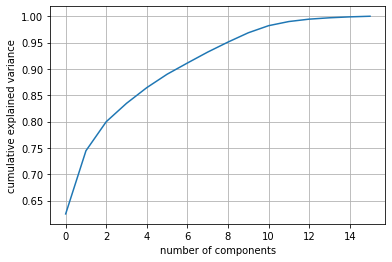

In [11]:
from sklearn.decomposition import PCA
pca = IncrementalPCA().fit(data['S8'])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.grid()
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
pca.explained_variance_ratio_

In [12]:
pca = IncrementalPCA(n_components = 2)

data['S8'] = pca.fit_transform(data['S8'])
data['S7'] = pca.fit_transform(data['S7'])
data['S6'] = pca.fit_transform(data['S6'])
data['S5'] = pca.fit_transform(data['S5'])
data['S4'] = pca.fit_transform(data['S4'])

In [13]:
data['S8']

array([[-3.52445567,  1.03987068],
       [ 8.00740168,  9.17519169],
       [-2.92261622,  3.29682118],
       ...,
       [ 4.97633547, -0.53557154],
       [ 1.72310634, -0.63243695],
       [ 2.47868279,  0.5176705 ]])

In [14]:
dfpca = pd.DataFrame(data['S8'], columns=['1st Principal Component', '2nd Principal Component'])

In [15]:
dfpca.sample(5)

,1st Principal Component,2nd Principal Component
1588,0.259641,-1.084206
646,-4.704511,1.852558
1983,4.826015,-0.010980
3105,-0.289951,1.083408
2830,3.573903,-0.041434


C:\Users\Zakky\anaconda3\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\Zakky\anaconda3\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


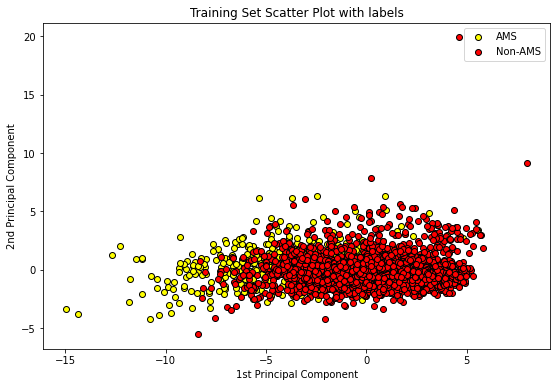

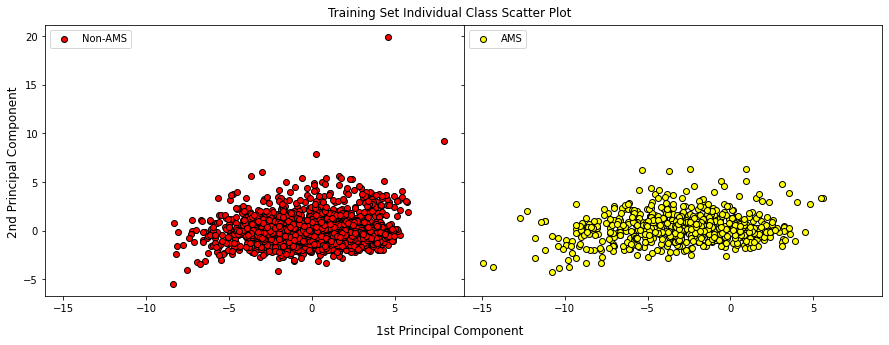

In [26]:
visualization_func(data['S8'], y_khs)


X = pd.DataFrame(data['S8'], columns=['a', 'b'])
X['y'] = y_khs

X_ams = X[X['y'] == 1]
X_nams = X[X['y'] == 0]

X_ams.drop(['y'], axis=1, inplace=True)
X_nams.drop(['y'], axis=1, inplace=True)

X_ams = X_ams.to_numpy()
X_nams = X_nams.to_numpy()

fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0)
fig.suptitle('Training Set Individual Class Scatter Plot', y=0.93)
fig.supxlabel('1st Principal Component')
fig.supylabel('2nd Principal Component', x=0.09)

ax[0].scatter(X_nams[:,0], X_nams[:,1], edgecolor='k', c='red', label='Non-AMS')
ax[0].legend()

ax[1].scatter(X_ams[:,0], X_ams[:,1], edgecolor='k', c='yellow', label='AMS')
ax[1].legend(loc='upper left')

plt.show()

### 4. Split train test

In [27]:
data['Xtr8'], data['Xte8'], data['ytr8'], data['yte8'] = train_test_split(data['S8'], y_khs, test_size=0.2, random_state=1234)
data['Xtr7'], data['Xte7'], data['ytr7'], data['yte7'] = train_test_split(data['S7'], y_khs, test_size=0.2, random_state=1234)
data['Xtr6'], data['Xte6'], data['ytr6'], data['yte6'] = train_test_split(data['S6'], y_khs, test_size=0.2, random_state=1234)
data['Xtr5'], data['Xte5'], data['ytr5'], data['yte5'] = train_test_split(data['S5'], y_khs, test_size=0.2, random_state=1234)
data['Xtr4'], data['Xte4'], data['ytr4'], data['yte4'] = train_test_split(data['S4'], y_khs, test_size=0.2, random_state=1234)

In [28]:
print('Train size', len(data['ytr8']))
print('Test size', len(data['yte8']))

Train size 2529
Test size 633


In [29]:
data['yte8']

2961    0
2177    1
883     0
1567    1
1674    1
       ..
507     1
92      1
1880    0
1660    1
2048    0
Name: AMS, Length: 633, dtype: int64

C:\Users\Zakky\anaconda3\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\Zakky\anaconda3\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\Zakky\anaconda3\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\Zakky\anaconda3\lib\site-packages\pan

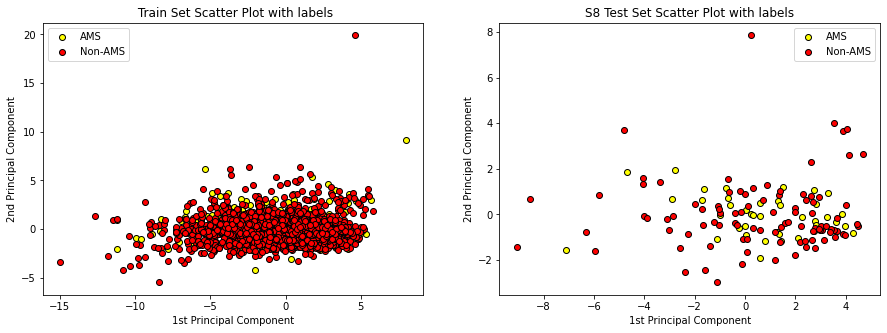

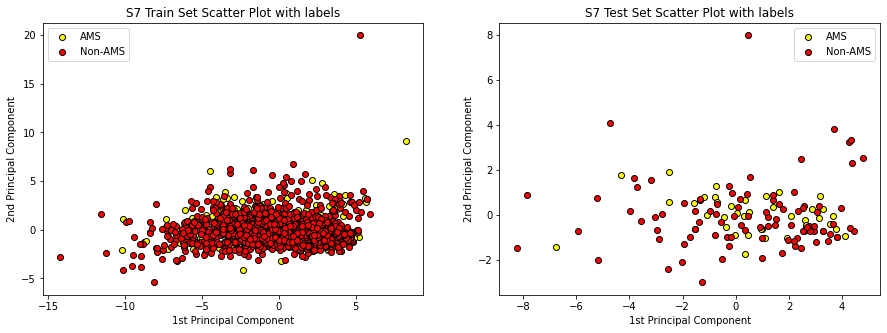

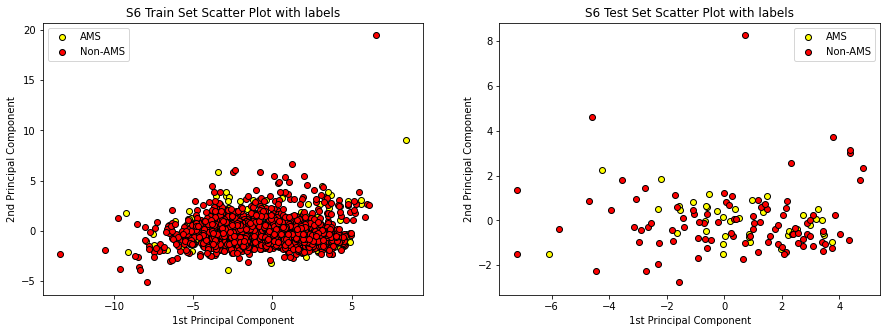

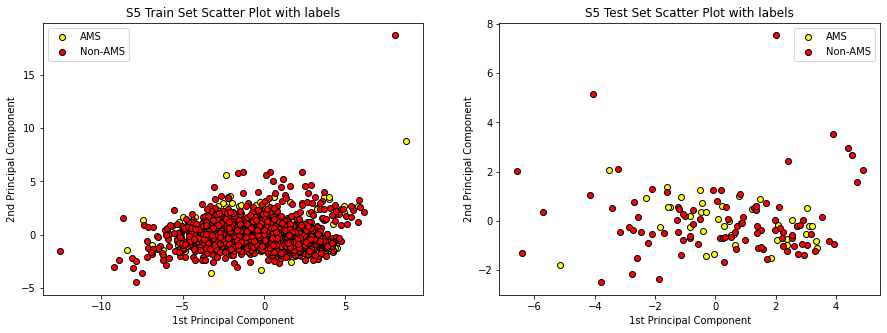

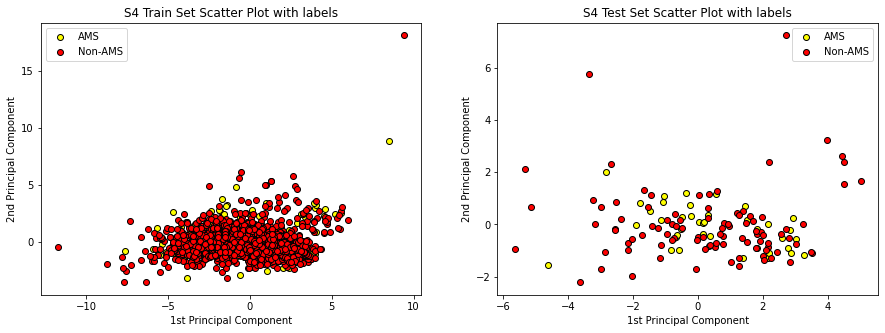

In [30]:
tr_te_visualization_func(data['Xtr8'], data['Xte8'], data['ytr8'], data['yte8'], '', 'S8')

tr_te_visualization_func(data['Xtr7'], data['Xte7'], data['ytr7'], data['yte7'], 'S7', 'S7')

tr_te_visualization_func(data['Xtr6'], data['Xte6'], data['ytr6'], data['yte6'], 'S6', 'S6')

tr_te_visualization_func(data['Xtr5'], data['Xte5'], data['ytr5'], data['yte5'], 'S5', 'S5')

tr_te_visualization_func(data['Xtr4'], data['Xte4'], data['ytr4'], data['yte4'], 'S4', 'S4')

### 5. Implement SMOTEENN on training data

In [31]:
counter = Counter(data['ytr8'])
print('Before SMOTEENN :', counter)

Before SMOTEENN : Counter({0: 2026, 1: 503})


In [32]:
smotetm = SMOTEENN()

data['Xtrsm8'], data['ytrsm8'] = smotetm.fit_resample(data['Xtr8'], data['ytr8'])
data['Xtrsm7'], data['ytrsm7'] = smotetm.fit_resample(data['Xtr7'], data['ytr7'])
data['Xtrsm6'], data['ytrsm6'] = smotetm.fit_resample(data['Xtr6'], data['ytr6'])
data['Xtrsm5'], data['ytrsm5'] = smotetm.fit_resample(data['Xtr5'], data['ytr5'])
data['Xtrsm4'], data['ytrsm4'] = smotetm.fit_resample(data['Xtr4'], data['ytr4'])

#### Save SMOTEENN processed data to file - Skip to Load if data already saved as file

In [32]:
pd.concat([pd.DataFrame(data['Xtrsm8']), pd.DataFrame(data['ytrsm8'])],
          axis=1).to_csv('Datasets/SMOTEENN/trsm8.csv', index=False)
pd.concat([pd.DataFrame(data['Xtrsm7']), pd.DataFrame(data['ytrsm7'])],
          axis=1).to_csv('Datasets/SMOTEENN/trsm7.csv', index=False)
pd.concat([pd.DataFrame(data['Xtrsm6']), pd.DataFrame(data['ytrsm6'])],
          axis=1).to_csv('Datasets/SMOTEENN/trsm6.csv', index=False)
pd.concat([pd.DataFrame(data['Xtrsm5']), pd.DataFrame(data['ytrsm5'])],
          axis=1).to_csv('Datasets/SMOTEENN/trsm5.csv', index=False)
pd.concat([pd.DataFrame(data['Xtrsm4']), pd.DataFrame(data['ytrsm4'])],
          axis=1).to_csv('Datasets/SMOTEENN/trsm4.csv', index=False)

#### Load SMOTEENN processed data from file

In [33]:
data['Xtrsm8'] = pd.read_csv('Datasets/SMOTEENN/trsm8.csv', usecols=['0', '1']).to_numpy()
data['Xtrsm7'] = pd.read_csv('Datasets/SMOTEENN/trsm7.csv', usecols=['0', '1']).to_numpy()
data['Xtrsm6'] = pd.read_csv('Datasets/SMOTEENN/trsm6.csv', usecols=['0', '1']).to_numpy()
data['Xtrsm5'] = pd.read_csv('Datasets/SMOTEENN/trsm5.csv', usecols=['0', '1']).to_numpy()
data['Xtrsm4'] = pd.read_csv('Datasets/SMOTEENN/trsm4.csv', usecols=['0', '1']).to_numpy()

data['ytrsm8'] = pd.read_csv('Datasets/SMOTEENN/trsm8.csv', usecols=['AMS']).squeeze()
data['ytrsm7'] = pd.read_csv('Datasets/SMOTEENN/trsm7.csv', usecols=['AMS']).squeeze()
data['ytrsm6'] = pd.read_csv('Datasets/SMOTEENN/trsm6.csv', usecols=['AMS']).squeeze()
data['ytrsm5'] = pd.read_csv('Datasets/SMOTEENN/trsm5.csv', usecols=['AMS']).squeeze()
data['ytrsm4'] = pd.read_csv('Datasets/SMOTEENN/trsm4.csv', usecols=['AMS']).squeeze()

In [34]:
data['ytrsm8']

0       0
1       0
2       0
3       0
4       0
       ..
2325    1
2326    1
2327    1
2328    1
2329    1
Name: AMS, Length: 2330, dtype: int64

In [35]:
counter = Counter(data['ytrsm8'])
print('After SMOTEENN :', counter)

After SMOTEENN : Counter({1: 1208, 0: 1122})


C:\Users\Zakky\anaconda3\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\Zakky\anaconda3\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\Zakky\anaconda3\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\Zakky\anaconda3\lib\site-packages\pan

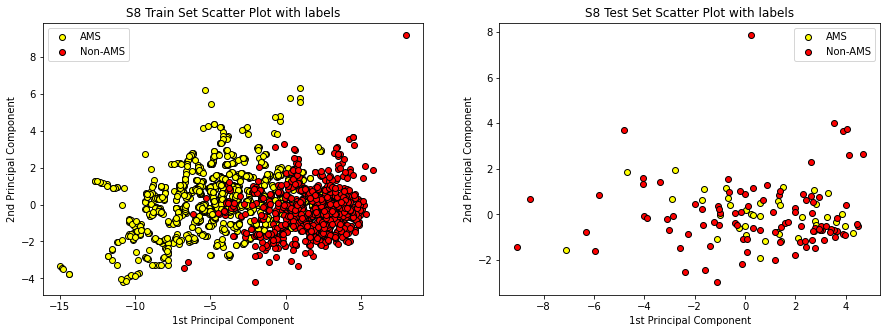

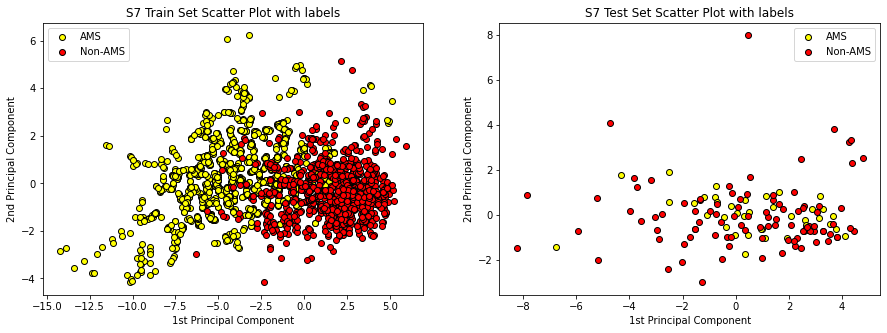

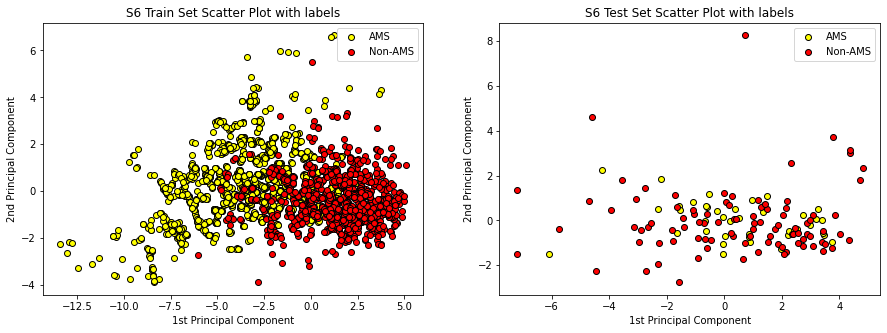

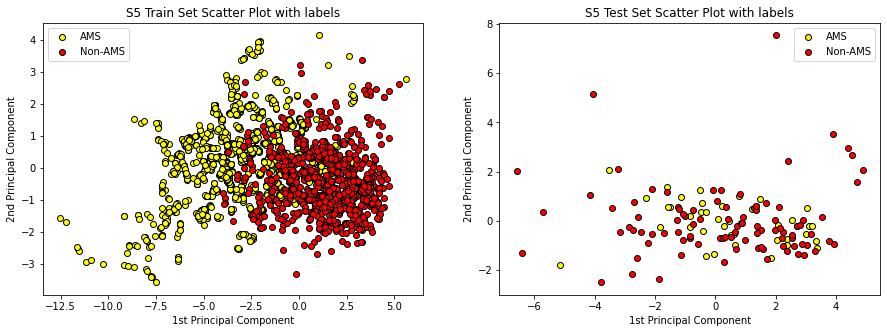

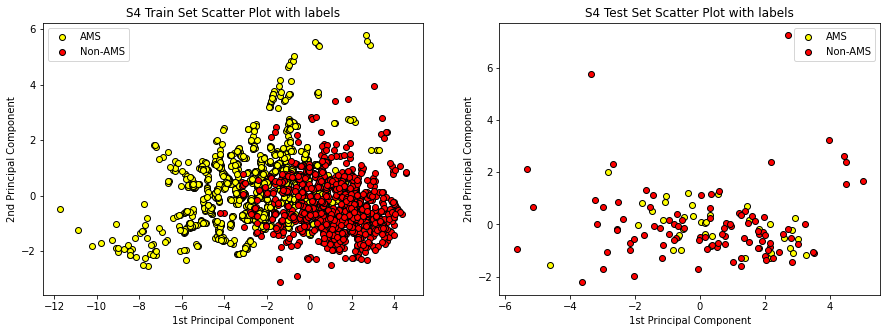

In [36]:
#tr_te_visualization_func(X_trsm, X_te, y_trsm, y_te)
tr_te_visualization_func(data['Xtrsm8'], data['Xte8'], data['ytrsm8'], data['yte8'], 'S8', 'S8')
tr_te_visualization_func(data['Xtrsm7'], data['Xte7'], data['ytrsm7'], data['yte7'], 'S7', 'S7')
tr_te_visualization_func(data['Xtrsm6'], data['Xte6'], data['ytrsm6'], data['yte6'], 'S6', 'S6')
tr_te_visualization_func(data['Xtrsm5'], data['Xte5'], data['ytrsm5'], data['yte5'], 'S5', 'S5')
tr_te_visualization_func(data['Xtrsm4'], data['Xte4'], data['ytrsm4'], data['yte4'], 'S4', 'S4')

### Default Config Logres

In [37]:
scoring = {'accuracy' : make_scorer(accuracy_score),
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score),
           'f1_score' : make_scorer(f1_score)}

In [38]:
log_pipe = Pipeline([('logres', LogisticRegression())])

logres_default_validation_func(data['Xtrsm8'], data['ytrsm8'], 'S8')
logres_default_validation_func(data['Xtrsm7'], data['ytrsm7'], 'S7')
logres_default_validation_func(data['Xtrsm6'], data['ytrsm6'], 'S6')
logres_default_validation_func(data['Xtrsm5'], data['ytrsm5'], 'S5')
logres_default_validation_func(data['Xtrsm4'], data['ytrsm4'], 'S4')

S8 Evaluation Score
Accuracy : 0.8897
Precision : 0.9016
Recall : 0.8841
f1 score : 0.8926

S7 Evaluation Score
Accuracy : 0.8975
Precision : 0.9008
Recall : 0.9042
f1 score : 0.9021

S6 Evaluation Score
Accuracy : 0.8904
Precision : 0.8925
Recall : 0.9044
f1 score : 0.8980

S5 Evaluation Score
Accuracy : 0.8748
Precision : 0.8830
Recall : 0.8836
f1 score : 0.8827

S4 Evaluation Score
Accuracy : 0.8651
Precision : 0.8718
Recall : 0.8779
f1 score : 0.8745



### Parameter Tuning LogRes

In [39]:
logres_parameter_tuning_func(data['Xtrsm8'], data['ytrsm8'], 'accuracy', 'S8')
logres_parameter_tuning_func(data['Xtrsm7'], data['ytrsm7'], 'accuracy', 'S7')
logres_parameter_tuning_func(data['Xtrsm6'], data['ytrsm6'], 'accuracy', 'S6')
logres_parameter_tuning_func(data['Xtrsm5'], data['ytrsm5'], 'accuracy', 'S5')
logres_parameter_tuning_func(data['Xtrsm4'], data['ytrsm4'], 'accuracy', 'S4')

S8 Best parameter :  {'logres__C': 0.001, 'logres__max_iter': 500}
S8 Best accuracy : 0.8957

S7 Best parameter :  {'logres__C': 0.1, 'logres__max_iter': 500}
S7 Best accuracy : 0.8975

S6 Best parameter :  {'logres__C': 1.0, 'logres__max_iter': 500}
S6 Best accuracy : 0.8904

S5 Best parameter :  {'logres__C': 0.001, 'logres__max_iter': 500}
S5 Best accuracy : 0.8788

S4 Best parameter :  {'logres__C': 0.001, 'logres__max_iter': 500}
S4 Best accuracy : 0.8776



#### Fit optimal parameter

In [40]:
logres_fit_parameter_func(data['Xtrsm8'], data['ytrsm8'], 0.001, 500, 'S8')
logres_fit_parameter_func(data['Xtrsm7'], data['ytrsm7'], 0.1, 500, 'S7')
logres_fit_parameter_func(data['Xtrsm6'], data['ytrsm6'], 1, 500, 'S6')
logres_fit_parameter_func(data['Xtrsm5'], data['ytrsm5'], 0.001, 500, 'S5')
logres_fit_parameter_func(data['Xtrsm4'], data['ytrsm4'], 0.001, 500, 'S4')

S8 Optimal Parameter Validation Score
Accuracy : 0.8957
Precision : 0.9076
Recall : 0.8899
f1 score : 0.8984

S7 Optimal Parameter Validation Score
Accuracy : 0.8975
Precision : 0.9008
Recall : 0.9042
f1 score : 0.9021

S6 Optimal Parameter Validation Score
Accuracy : 0.8904
Precision : 0.8925
Recall : 0.9044
f1 score : 0.8980

S5 Optimal Parameter Validation Score
Accuracy : 0.8788
Precision : 0.8876
Recall : 0.8861
f1 score : 0.8864

S4 Optimal Parameter Validation Score
Accuracy : 0.8776
Precision : 0.8722
Recall : 0.9053
f1 score : 0.8880



### Logistic Regression Test Score

#### Default Config

In [42]:
model_log = LogisticRegression(C=0.001).fit(data['Xtrsm8'], data['ytrsm8'])
print('Model trained with sem8 data')
test_score_func(model_log, data['Xte8'], data['yte8'], 'S8')
test_score_func(model_log, data['Xte7'], data['yte7'], 'S7')
test_score_func(model_log, data['Xte6'], data['yte6'], 'S6')
test_score_func(model_log, data['Xte5'], data['yte5'], 'S5')
test_score_func(model_log, data['Xte4'], data['yte4'], 'S4')

#model_log = LogisticRegression().fit(data['Xtrsm4'], data['ytrsm4'])
#print('Model trained with sem4 data')
#test_score_func(model_log, data['Xte8'], data['yte8'], 'S8')
#test_score_func(model_log, data['Xte7'], data['yte7'], 'S7')
#test_score_func(model_log, data['Xte6'], data['yte6'], 'S6')
#test_score_func(model_log, data['Xte5'], data['yte5'], 'S5')
#test_score_func(model_log, data['Xte4'], data['yte4'], 'S4')

Model trained with sem8 data
S8 Test Score
Accuracy : 0.7551
Precision : 0.3918
Recall : 0.6726
F1 score : 0.4951

S7 Test Score
Accuracy : 0.7314
Precision : 0.3596
Recall : 0.6460
F1 score : 0.4620

S6 Test Score
Accuracy : 0.7330
Precision : 0.3586
Recall : 0.6283
F1 score : 0.4566

S5 Test Score
Accuracy : 0.7267
Precision : 0.3529
Recall : 0.6372
F1 score : 0.4543

S4 Test Score
Accuracy : 0.7299
Precision : 0.3550
Recall : 0.6283
F1 score : 0.4537



C:\Users\Zakky\anaconda3\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


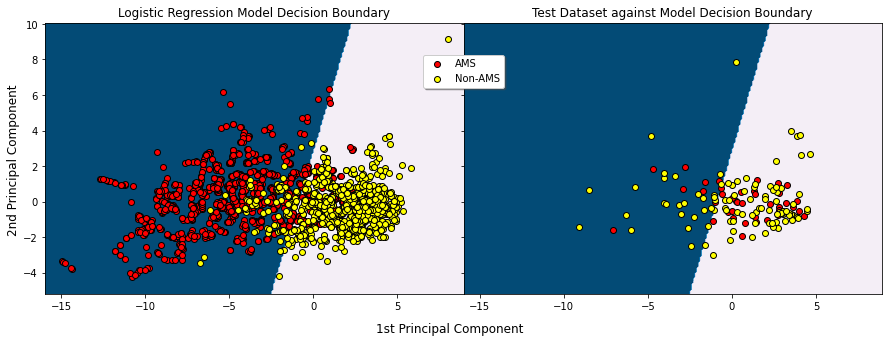

In [43]:
# plotting the decision boundary in the scatter plot of Training and Test Set with labels indicated by colors
X_trsm = data['Xtrsm8']
y_trsm = data['ytrsm8']

x_min, x_max = X_trsm[:, 0].min() - 1, X_trsm[:, 0].max() + 1
y_min, y_max = X_trsm[:, 1].min() - 1, X_trsm[:, 1].max() + 1

xx_train, yy_train = np.meshgrid(np.arange(x_min, x_max, 0.1),
                                 np.arange(y_min, y_max, 0.1))

Z_train = model_log.predict(np.c_[xx_train.ravel(), yy_train.ravel()])
Z_train = Z_train.reshape(xx_train.shape)
########################################################################
X_te = data['Xte8']
y_te = data['yte8']

#x_min, x_max = X_te[:, 0].min() - 1, X_te[:, 0].max() + 1
#y_min, y_max = X_te[:, 1].min() - 1, X_te[:, 1].max() + 1

xx_test, yy_test = np.meshgrid(np.arange(x_min, x_max, 0.1),
                               np.arange(y_min, y_max, 0.1))

Z_test = model_log.predict(np.c_[xx_test.ravel(), yy_test.ravel()])
Z_test = Z_test.reshape(xx_test.shape)
#########################################################################



X_trsm = pd.DataFrame(X_trsm, columns=['a', 'b'])
X_trsm['y'] = y_trsm
X_te = pd.DataFrame(X_te, columns=['a', 'b'])
X_te['y'] = y_te

Xtr_ams = X_trsm[X_trsm['y'] == 1]
Xtr_nams = X_trsm[X_trsm['y'] == 0]
Xte_ams = X_te[X_te['y'] == 1]
Xte_nams = X_te[X_te['y'] == 0]

Xtr_ams.drop(['y'], axis=1, inplace=True)
Xtr_nams.drop(['y'], axis=1, inplace=True)
Xte_ams.drop(['y'], axis=1, inplace=True)
Xte_nams.drop(['y'], axis=1, inplace=True)

Xtr_ams = Xtr_ams.to_numpy()
Xtr_nams = Xtr_nams.to_numpy()
Xte_ams = Xte_ams.to_numpy()
Xte_nams = Xte_nams.to_numpy()


fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0)
fig.supxlabel('1st Principal Component')
fig.supylabel('2nd Principal Component', x=0.09)

ax[0].contourf(xx_train, yy_train, Z_train, cmap='PuBu')
ax[0].scatter(Xtr_ams[:, 0], Xtr_ams[:, 1], c='red', edgecolor='k', label='AMS')
ax[0].scatter(Xtr_nams[:, 0], Xtr_nams[:, 1], c='yellow', edgecolor='k', label='Non-AMS')
ax[0].set_title('Logistic Regression Model Decision Boundary')


ax[1].contourf(xx_test, yy_test, Z_test, cmap='PuBu')
ax[1].scatter(Xte_ams[:, 0], Xte_ams[:, 1], c='red', edgecolor='k', label='AMS')
ax[1].scatter(Xte_nams[:, 0], Xte_nams[:, 1], c='yellow', edgecolor='k', label='Non-AMS')
ax[1].set_title('Test Dataset against Model Decision Boundary')
ax[1].legend(loc='upper center', bbox_to_anchor=(0, .9), shadow=True)
plt.savefig('logres_decision_boundary.png', bbox_inches='tight')
plt.show()


In [48]:
res=model_log.predict(data['Xte8'])

In [49]:
log_metrics = {}
log_metrics['acc'] = accuracy_score(y_te, res)
log_metrics['pre'] = precision_score(y_te, res)
log_metrics['rec'] = recall_score(y_te, res)
log_metrics['f1'] = f1_score(y_te, res)

In [52]:
print('Test Score', log_metrics)

Test Score {'acc': 0.7551342812006319, 'pre': 0.3917525773195876, 'rec': 0.672566371681416, 'f1': 0.495114006514658}


### Default Config kNN

In [44]:
knn_pipe = Pipeline([('knn', KNeighborsClassifier())])

knn_default_validation_func(data['Xtrsm8'], data['ytrsm8'], 'S8')
knn_default_validation_func(data['Xtrsm7'], data['ytrsm7'], 'S7')
knn_default_validation_func(data['Xtrsm6'], data['ytrsm6'], 'S6')
knn_default_validation_func(data['Xtrsm5'], data['ytrsm5'], 'S5')
knn_default_validation_func(data['Xtrsm4'], data['ytrsm4'], 'S4')

S8 Evaluation Score
Accuracy : 0.9605
Precision : 0.9550
Recall : 0.9702
f1 score : 0.9623

S7 Evaluation Score
Accuracy : 0.9602
Precision : 0.9512
Recall : 0.9744
f1 score : 0.9625

S6 Evaluation Score
Accuracy : 0.9560
Precision : 0.9502
Recall : 0.9687
f1 score : 0.9591

S5 Evaluation Score
Accuracy : 0.9577
Precision : 0.9464
Recall : 0.9764
f1 score : 0.9610

S4 Evaluation Score
Accuracy : 0.9564
Precision : 0.9487
Recall : 0.9717
f1 score : 0.9599



### Parameter Tuning kNN

In [54]:
import math
math.sqrt(len(data['ytrsm8']))

48.27007354458868

Minimum error:- 0.2575039494470774 at K = 15


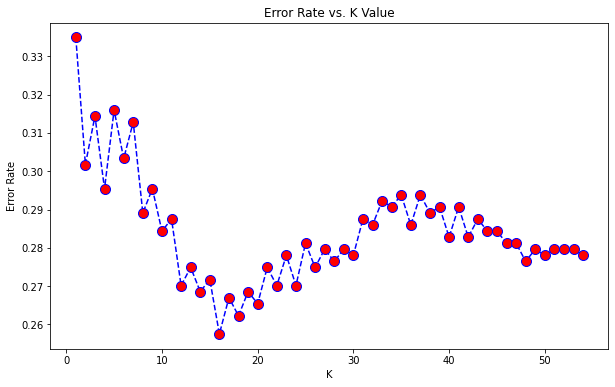

In [45]:
error_rate = []
for i in range(1,55):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(data['Xtrsm8'],data['ytrsm8'])
    pred_i = knn.predict(data['Xte8'])
    error_rate.append(np.mean(pred_i != data['yte8']))

plt.figure(figsize=(10,6))
plt.plot(range(1,55),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

In [46]:
k_range = range(1, 53)
weight_options = ['uniform', 'distance']

knn_parameter_tuning_func(data['Xtrsm8'], data['ytrsm8'], 'accuracy', 'S8')
knn_parameter_tuning_func(data['Xtrsm7'], data['ytrsm7'], 'accuracy', 'S7')
knn_parameter_tuning_func(data['Xtrsm6'], data['ytrsm6'], 'accuracy', 'S6')
knn_parameter_tuning_func(data['Xtrsm5'], data['ytrsm5'], 'accuracy', 'S5')
knn_parameter_tuning_func(data['Xtrsm4'], data['ytrsm4'], 'accuracy', 'S4')

S8 Best Parameters :  {'knn__n_neighbors': 1, 'knn__weights': 'uniform'}
S8 Best  accuracy  : 0.9871
S7 Best Parameters :  {'knn__n_neighbors': 1, 'knn__weights': 'uniform'}
S7 Best  accuracy  : 0.9896
S6 Best Parameters :  {'knn__n_neighbors': 1, 'knn__weights': 'uniform'}
S6 Best  accuracy  : 0.9899
S5 Best Parameters :  {'knn__n_neighbors': 1, 'knn__weights': 'uniform'}
S5 Best  accuracy  : 0.9901
S4 Best Parameters :  {'knn__n_neighbors': 1, 'knn__weights': 'uniform'}
S4 Best  accuracy  : 0.9915


#### fit optimal parameter

In [47]:
knn_fit_parameter_func(data['Xtrsm8'], data['ytrsm8'], 15, 'distance', 'S8')
knn_fit_parameter_func(data['Xtrsm7'], data['ytrsm7'], 47, 'uniform', 'S7')
knn_fit_parameter_func(data['Xtrsm6'], data['ytrsm6'], 47, 'uniform', 'S6')
knn_fit_parameter_func(data['Xtrsm5'], data['ytrsm5'], 47, 'uniform', 'S5')
knn_fit_parameter_func(data['Xtrsm4'], data['ytrsm4'], 47, 'uniform', 'S4')

S8 Optimal Parameter Validation Score
Accuracy : 0.9639
Precision : 0.9508
Recall : 0.9818
f1 score : 0.9659

S7 Optimal Parameter Validation Score
Accuracy : 0.9039
Precision : 0.9105
Recall : 0.9059
f1 score : 0.9080

S6 Optimal Parameter Validation Score
Accuracy : 0.8882
Precision : 0.9026
Recall : 0.8880
f1 score : 0.8944

S5 Optimal Parameter Validation Score
Accuracy : 0.8829
Precision : 0.8858
Recall : 0.8971
f1 score : 0.8911

S4 Optimal Parameter Validation Score
Accuracy : 0.8758
Precision : 0.8860
Recall : 0.8821
f1 score : 0.8839



### kNN Test Score

#### Default Configuration

In [48]:
model_knn = KNeighborsClassifier().fit(data['Xtrsm8'], data['ytrsm8'])
print('Model trained with sem8 data')
test_score_func(model_knn, data['Xte8'], data['yte8'], 'S8')
test_score_func(model_knn, data['Xte7'], data['yte7'], 'S7')
test_score_func(model_knn, data['Xte6'], data['yte6'], 'S6')
test_score_func(model_knn, data['Xte5'], data['yte5'], 'S5')
test_score_func(model_knn, data['Xte4'], data['yte4'], 'S4')

model_knn = KNeighborsClassifier().fit(data['Xtrsm4'], data['ytrsm4'])
print('Model trained with sem4 data')
test_score_func(model_knn, data['Xte8'], data['yte8'], 'S8')
test_score_func(model_knn, data['Xte7'], data['yte7'], 'S7')
test_score_func(model_knn, data['Xte6'], data['yte6'], 'S6')
test_score_func(model_knn, data['Xte5'], data['yte5'], 'S5')
test_score_func(model_knn, data['Xte4'], data['yte4'], 'S4')

Model trained with sem8 data
S8 Test Score
Accuracy : 0.6840
Precision : 0.3117
Recall : 0.6372
F1 score : 0.4186

S7 Test Score
Accuracy : 0.6825
Precision : 0.3103
Recall : 0.6372
F1 score : 0.4174

S6 Test Score
Accuracy : 0.6935
Precision : 0.3184
Recall : 0.6283
F1 score : 0.4226

S5 Test Score
Accuracy : 0.6967
Precision : 0.3180
Recall : 0.6106
F1 score : 0.4182

S4 Test Score
Accuracy : 0.6714
Precision : 0.2870
Recall : 0.5664
F1 score : 0.3810

Model trained with sem4 data
S8 Test Score
Accuracy : 0.7188
Precision : 0.3556
Recall : 0.7080
F1 score : 0.4734

S7 Test Score
Accuracy : 0.6983
Precision : 0.3274
Recall : 0.6549
F1 score : 0.4366

S6 Test Score
Accuracy : 0.6651
Precision : 0.2929
Recall : 0.6195
F1 score : 0.3977

S5 Test Score
Accuracy : 0.6888
Precision : 0.3108
Recall : 0.6106
F1 score : 0.4119

S4 Test Score
Accuracy : 0.6746
Precision : 0.3054
Recall : 0.6460
F1 score : 0.4148



In [49]:
model_knn = KNeighborsClassifier(n_neighbors=15, weights='distance').fit(data['Xtrsm8'], data['ytrsm8'])

C:\Users\Zakky\anaconda3\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
No handles with labels found to put in legend.


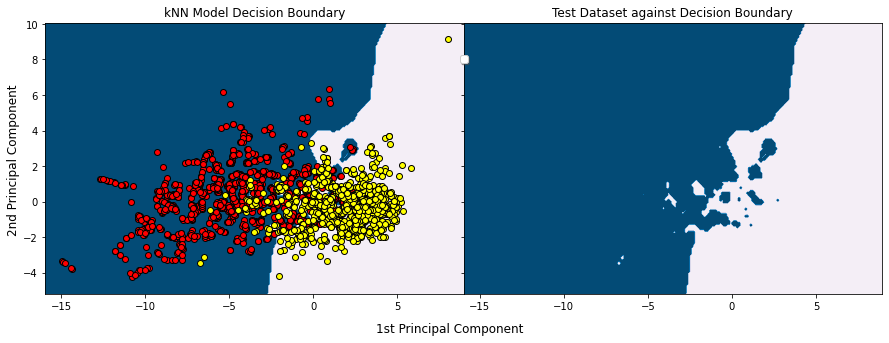

In [51]:
# plotting the decision boundary in the scatter plot of Training and Test Set with labels indicated by colors
X_trsm = data['Xtrsm8']
y_trsm = data['ytrsm8']

x_min, x_max = X_trsm[:, 0].min() - 1, X_trsm[:, 0].max() + 1
y_min, y_max = X_trsm[:, 1].min() - 1, X_trsm[:, 1].max() + 1

xx_train, yy_train = np.meshgrid(np.arange(x_min, x_max, 0.1),
                                 np.arange(y_min, y_max, 0.1))

Z_train = model_knn.predict(np.c_[xx_train.ravel(), yy_train.ravel()])
Z_train = Z_train.reshape(xx_train.shape)
########################################################################
X_te = data['Xte8']
y_te = data['yte8']

#x_min, x_max = X_te[:, 0].min() - 1, X_te[:, 0].max() + 1
#y_min, y_max = X_te[:, 1].min() - 1, X_te[:, 1].max() + 1

xx_test, yy_test = np.meshgrid(np.arange(x_min, x_max, 0.1),
                               np.arange(y_min, y_max, 0.1))

Z_test = model_knn.predict(np.c_[xx_test.ravel(), yy_test.ravel()])
Z_test = Z_test.reshape(xx_test.shape)
#########################################################################



X_trsm = pd.DataFrame(X_trsm, columns=['a', 'b'])
X_trsm['y'] = y_trsm
X_te = pd.DataFrame(X_te, columns=['a', 'b'])
X_te['y'] = y_te

Xtr_ams = X_trsm[X_trsm['y'] == 1]
Xtr_nams = X_trsm[X_trsm['y'] == 0]
Xte_ams = X_te[X_te['y'] == 1]
Xte_nams = X_te[X_te['y'] == 0]

Xtr_ams.drop(['y'], axis=1, inplace=True)
Xtr_nams.drop(['y'], axis=1, inplace=True)
Xte_ams.drop(['y'], axis=1, inplace=True)
Xte_nams.drop(['y'], axis=1, inplace=True)

Xtr_ams = Xtr_ams.to_numpy()
Xtr_nams = Xtr_nams.to_numpy()
Xte_ams = Xte_ams.to_numpy()
Xte_nams = Xte_nams.to_numpy()


fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0.1)
fig.supxlabel('1st Principal Component')
fig.supylabel('2nd Principal Component', x=0.09)

ax[0].contourf(xx_train, yy_train, Z_train, cmap='PuBu')
ax[0].scatter(Xtr_ams[:, 0], Xtr_ams[:, 1], c='red', edgecolor='k', label='AMS')
ax[0].scatter(Xtr_nams[:, 0], Xtr_nams[:, 1], c='yellow', edgecolor='k', label='Non-AMS')
ax[0].set_title('kNN Model Decision Boundary')

ax[1].contourf(xx_test, yy_test, Z_test, cmap='PuBu')
#ax[1].scatter(Xte_ams[:, 0], Xte_ams[:, 1], c='red', edgecolor='k', label='AMS')
#ax[1].scatter(Xte_nams[:, 0], Xte_nams[:, 1], c='yellow', edgecolor='k', label='Non-AMS')
ax[1].set_title('Test Dataset against Decision Boundary')
ax[1].legend(loc='upper center', bbox_to_anchor=(0, .9), shadow=True)


plt.savefig('knn_decision_boundary.png', bbox_inches='tight')
plt.show()

In [67]:
res=model_knn.predict(X_te)

In [68]:
knn_metrics = {}
knn_metrics['acc'] = accuracy_score(y_te, res)
knn_metrics['pre'] = precision_score(y_te, res)
knn_metrics['rec'] = recall_score(y_te, res)
knn_metrics['f1'] = f1_score(y_te, res)

In [72]:
print('Validation Score', val_knn_metrics)

Validation Score {'acc': 0.7393364928909952, 'pre': 0.4155844155844156, 'rec': 0.7619047619047619, 'f1': 0.5378151260504201}


In [70]:
print('Test Score', knn_metrics)

Test Score {'acc': 0.7393364928909952, 'pre': 0.4155844155844156, 'rec': 0.7619047619047619, 'f1': 0.5378151260504201}


### Functions

In [17]:
def visualization_func(X, y):
    X = pd.DataFrame(X, columns=['p1', 'p2'])

    X['AMS'] = y

    X_ams = X[X['AMS'] == 1]
    X_nams = X[X['AMS'] == 0]

    X_ams.drop(['AMS'], axis=1, inplace=True)
    X_nams.drop(['AMS'], axis=1, inplace=True)
    
    X_ams = X_ams.to_numpy()
    X_nams = X_nams.to_numpy()
    
    plt.figure(figsize = (20, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(X_ams[:,0], X_ams[:,1], c = 'yellow', edgecolors='k', label="AMS")
    plt.scatter(X_nams[:,0], X_nams[:,1], c = 'red', edgecolors='k', label='Non-AMS')
    plt.xlabel('1st Principal Component')
    plt.ylabel('2nd Principal Component')
    plt.title('Training Set Scatter Plot with labels')
    plt.legend()

In [18]:
def tr_te_visualization_func(Xtr, Xte, ytr, yte, tr_title, te_title):
    Xtr = pd.DataFrame(Xtr, columns=['p1', 'p2'])
    Xte = pd.DataFrame(Xte, columns=['p1', 'p2'])

    Xtr['AMS'] = ytr
    Xte['AMS'] = yte

    Xtr_ams = Xtr[Xtr['AMS'] == 1]
    Xtr_nams = Xtr[Xtr['AMS'] == 0]
    Xte_ams = Xte[Xte['AMS'] == 1]
    Xte_nams = Xte[Xte['AMS'] == 0]

    Xtr_ams.drop(['AMS'], axis=1, inplace=True)
    Xtr_nams.drop(['AMS'], axis=1, inplace=True)
    Xte_ams.drop(['AMS'], axis=1, inplace=True)
    Xte_nams.drop(['AMS'], axis=1, inplace=True)
    
    Xtr_ams = Xtr_ams.to_numpy()
    Xtr_nams = Xtr_nams.to_numpy()
    Xte_ams = Xte_ams.to_numpy()
    Xte_nams = Xte_nams.to_numpy()
    
    plt.figure(figsize = (15, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(Xtr_ams[:,0], Xtr_ams[:,1], c = 'yellow', edgecolors='k', label="AMS")
    plt.scatter(Xtr_nams[:,0], Xtr_nams[:,1], c = 'red', edgecolors='k', label='Non-AMS')
    plt.xlabel('1st Principal Component')
    plt.ylabel('2nd Principal Component')
    tr_title = tr_title + ' Train Set Scatter Plot with labels'
    plt.title(tr_title)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.scatter(Xte_ams[:,0], Xte_ams[:,1], c = 'yellow', edgecolors='k', label="AMS")
    plt.scatter(Xte_nams[:,0], Xte_nams[:,1], c = 'red', edgecolors='k', label='Non-AMS')
    plt.xlabel('1st Principal Component')
    plt.ylabel('2nd Principal Component')
    te_title = te_title + ' Test Set Scatter Plot with labels'
    plt.title(te_title)
    plt.legend()

In [19]:
def logres_default_validation_func(X_trsm, y_trsm, sem):

    log_score_sc = cross_validate(log_pipe, X_trsm, y_trsm, cv=10, scoring=scoring)
    
    print(sem, 'Evaluation Score')
    print('Accuracy : {:.4f}'.format(log_score_sc['test_accuracy'].mean()))
    print('Precision : {:.4f}'.format(log_score_sc['test_precision'].mean()))
    print('Recall : {:.4f}'.format(log_score_sc['test_recall'].mean()))
    print('f1 score : {:.4f}'.format(log_score_sc['test_f1_score'].mean()))
    print('')

In [20]:
def logres_parameter_tuning_func(X_trsm, y_trsm, score, sem):
    log_pipe = Pipeline([('logres', LogisticRegression())])
    log_params = [{'logres__max_iter' : [500, 1000, 5000],
                   'logres__C' : [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2]}]
    grid_log = GridSearchCV(log_pipe, param_grid=log_params, cv=10, scoring=score)
    
    grid_log.fit(X_trsm, y_trsm)
    
    print(sem, 'Best parameter : ', grid_log.best_params_)
    print(sem, 'Best accuracy : {:.4f}'.format(grid_log.best_score_))
    print('')

In [21]:
def logres_fit_parameter_func(X_trsm, y_trsm, C, max_iter, sem):
    log_pipe = Pipeline([('logres', LogisticRegression(C=C, max_iter=max_iter))])

    log_score_sc = cross_validate(log_pipe, X_trsm, y_trsm, cv=10, scoring=scoring)

    #val_log_metrics = {}
    #val_log_metrics['acc'] = log_score_sc['test_accuracy'].mean()
    #val_log_metrics['pre'] = log_score_sc['test_precision'].mean()
    #val_log_metrics['rec'] = log_score_sc['test_recall'].mean()
    #val_log_metrics['f1'] = log_score_sc['test_f1_score'].mean()
    
    print(sem, 'Optimal Parameter Validation Score')
    print('Accuracy : {:.4f}'.format(log_score_sc['test_accuracy'].mean()))
    print('Precision : {:.4f}'.format(log_score_sc['test_precision'].mean()))
    print('Recall : {:.4f}'.format(log_score_sc['test_recall'].mean()))
    print('f1 score : {:.4f}'.format(log_score_sc['test_f1_score'].mean()))
    print('')

In [22]:
def knn_default_validation_func(X_trsm, y_trsm, sem):
    scores = cross_validate(knn_pipe, X_trsm, y_trsm, cv=10, scoring=scoring)
    
    print(sem, 'Evaluation Score')
    print('Accuracy : {:.4f}'.format(scores['test_accuracy'].mean()))
    print('Precision : {:.4f}'.format(scores['test_precision'].mean()))
    print('Recall : {:.4f}'.format(scores['test_recall'].mean()))
    print('f1 score : {:.4f}'.format(scores['test_f1_score'].mean()))
    print('')

In [23]:
def knn_parameter_tuning_func(X_trsm, y_trsm, score, sem):
    param_grid = dict(knn__n_neighbors=k_range, knn__weights=weight_options)
    pipe = Pipeline([('knn', KNeighborsClassifier())])
    grid = GridSearchCV(pipe, param_grid, cv=10, scoring=score)
    
    grid.fit(X_trsm, y_trsm)
    
    print(sem, 'Best Parameters : ', grid.best_params_)
    print(sem, 'Best ', score, ' : {:.4f}'.format(grid.best_score_))

In [24]:
def knn_fit_parameter_func(X_trsm, y_trsm, n_neighbors, weights, sem):
    pipe = Pipeline([('knn', KNeighborsClassifier(n_neighbors = n_neighbors, weights=weights))])

    scores = cross_validate(pipe, X_trsm, y_trsm, cv=10, scoring=scoring)

    print(sem, 'Optimal Parameter Validation Score')
    print('Accuracy : {:.4f}'.format(scores['test_accuracy'].mean()))
    print('Precision : {:.4f}'.format(scores['test_precision'].mean()))
    print('Recall : {:.4f}'.format(scores['test_recall'].mean()))
    print('f1 score : {:.4f}'.format(scores['test_f1_score'].mean()))
    print('')

In [25]:
def test_score_func(model, X_te, y_te, sem):
    res=model.predict(X_te)
    print(sem, 'Test Score')
    print('Accuracy : {:.4f}'.format(accuracy_score(y_te, res)))
    print('Precision : {:.4f}'.format(precision_score(y_te, res)))
    print('Recall : {:.4f}'.format(recall_score(y_te, res)))
    print('F1 score : {:.4f}'.format(f1_score(y_te, res)))
    print('')